Adopted from:
https://colab.research.google.com/github/ruotianluo/ImageCaptioning.pytorch/blob/colab/notebooks/captioning_demo.ipynb

Library: https://github.com/faizanahemad/ImageCaptioning.pytorch.git

In [164]:
import pandas as pd
import numpy as np



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def print_code(func):
    import inspect
    from pygments import highlight
    from pygments.lexers import PythonLexer
    from pygments.formatters import TerminalFormatter

    code = "".join(inspect.getsourcelines(func)[0])
    print(highlight(code, PythonLexer(), TerminalFormatter()))


In [ ]:
# %pip install git+https://github.com/faizanahemad/ImageCaptioning.pytorch.git
%pip install gdown
!gdown --id 1VmUzgu0qlmCMqM1ajoOZxOXP3hiC_qlL
!gdown --id 1zQe00W02veVYq-hdq5WsPOS3OPkNdq79
!pip install yacs

!rm -rf vqa-maskrcnn-benchmark
!git clone https://gitlab.com/vedanuj/vqa-maskrcnn-benchmark.git
%cd vqa-maskrcnn-benchmark
!python setup.py build
!python setup.py develop
import sys
import os
DIR = os.getcwd()
sys.path.append(f'{DIR}/vqa-maskrcnn-benchmark')

%cd ..
%mkdir model_data
!wget -O model_data/detectron_model.pth wget https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_model.pth
!wget -O model_data/detectron_model.yaml wget https://dl.fbaipublicfiles.com/vilbert-multi-task/detectron_config.yaml
!pip uninstall -y captioning
%pip install git+https://github.com/faizanahemad/ImageCaptioning.pytorch.git


In [2]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [162]:
import yaml
import cv2
import torch
import requests
import numpy as np
import gc
import torch.nn.functional as F
import pandas as pd

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout
from io import BytesIO

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.layers import nms
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.utils.model_serialization import load_state_dict


class FeatureExtractor:
    TARGET_IMAGE_SIZE = [448, 448]
    CHANNEL_MEAN = [0.485, 0.456, 0.406]
    CHANNEL_STD = [0.229, 0.224, 0.225]

    def __init__(self):
        # self._init_processors()
        self.detection_model = self._build_detection_model()

    def __call__(self, url):
        with torch.no_grad():
            detectron_features = self.get_detectron_features(url)

        return detectron_features

    def _build_detection_model(self):

        cfg.merge_from_file('model_data/detectron_model.yaml')
        cfg.freeze()

        model = build_detection_model(cfg)
        checkpoint = torch.load('model_data/detectron_model.pth',
                                map_location=torch.device("cpu"))

        load_state_dict(model, checkpoint.pop("model"))

        model.to(device)
        model.eval()
        return model

    def get_actual_image(self, image_path):
        if image_path.startswith('http'):
            path = requests.get(image_path, stream=True).raw
        else:
            path = image_path

        return path

    def _image_transform(self, image_path):
        path = self.get_actual_image(image_path)

        img = Image.open(path).convert('RGB')
        im = np.array(img).astype(np.float32)
        im = im[:, :, ::-1]
        im -= np.array([102.9801, 115.9465, 122.7717])
        im_shape = im.shape
        im_size_min = np.min(im_shape[0:2])
        im_size_max = np.max(im_shape[0:2])
        im_scale = float(800) / float(im_size_min)
        # Prevent the biggest axis from being more than max_size
        if np.round(im_scale * im_size_max) > 1333:
            im_scale = float(1333) / float(im_size_max)
        im = cv2.resize(
            im,
            None,
            None,
            fx=im_scale,
            fy=im_scale,
            interpolation=cv2.INTER_LINEAR
        )
        img = torch.from_numpy(im).permute(2, 0, 1)
        return img, im_scale

    def _process_feature_extraction(self, output,
                                    im_scales,
                                    feat_name='fc6',
                                    conf_thresh=0.2):
        batch_size = len(output[0]["proposals"])
        n_boxes_per_image = [len(_) for _ in output[0]["proposals"]]
        score_list = output[0]["scores"].split(n_boxes_per_image)
        score_list = [torch.nn.functional.softmax(x, -1) for x in score_list]
        feats = output[0][feat_name].split(n_boxes_per_image)
        cur_device = score_list[0].device

        feat_list = []

        for i in range(batch_size):
            dets = output[0]["proposals"][i].bbox / im_scales[i]
            scores = score_list[i]

            max_conf = torch.zeros((scores.shape[0])).to(cur_device)

            for cls_ind in range(1, scores.shape[1]):
                cls_scores = scores[:, cls_ind]
                keep = nms(dets, cls_scores, 0.5)
                max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                             cls_scores[keep],
                                             max_conf[keep])

            keep_boxes = torch.argsort(max_conf, descending=True)[:100]
            feat_list.append(feats[i][keep_boxes])
            
        return feat_list

    def get_detectron_features(self, image_path):
        _ = gc.collect()
        im, im_scale = self._image_transform(image_path)
        img_tensor, im_scales = [im], [im_scale]
        current_img_list = to_image_list(img_tensor, size_divisible=32)
        current_img_list = current_img_list.to(device)
        with torch.no_grad():
            output = self.detection_model(current_img_list)
        print(output[0].keys(), output[0]['fc6'].shape, len(output[0]["proposals"]), [len(_) for _ in output[0]["proposals"]])
        feat_list = self._process_feature_extraction(output, im_scales,
                                                     'fc6', 0.2)
        return feat_list[0]

feature_extractor = FeatureExtractor()
    

In [9]:

import captioning
import captioning.utils.misc
import captioning.models
infos = captioning.utils.misc.pickle_load(open('infos_trans12-best.pkl', 'rb'))

infos['opt'].vocab = infos['vocab']
model = captioning.models.setup(infos['opt'])
_ = model.to(device)
_ = model.load_state_dict(torch.load('model-best.pth', map_location=device))


In [78]:

def get_captions(image_text):
    img_feature = feature_extractor(image_text)
    print(img_feature[:4, :8])
    # Return the 5 captions from beam serach with beam size 5
    processed_by_model = model(img_feature.mean(0)[None], img_feature[None], mode='sample', 
                                       opt={'beam_size':5, 'sample_method':'beam_search', 'sample_n':5})
    
#     print(processed_by_model[1], processed_by_model[0].shape, processed_by_model[1].shape)
    sents = model.decode_sequence(processed_by_model[0])
    
    return sents


In [128]:
import inspect
inspect.getsourcelines(model._prepare_feature_forward)

(['    def _prepare_feature_forward(self, att_feats, att_masks=None, seq=None):\n',
  '        att_feats, att_masks = self.clip_att(att_feats, att_masks)\n',
  '\n',
  '        att_feats = pack_wrapper(self.att_embed, att_feats, att_masks)\n',
  '\n',
  '        if att_masks is None:\n',
  '            att_masks = att_feats.new_ones(att_feats.shape[:2], dtype=torch.long)\n',
  '        att_masks = att_masks.unsqueeze(-2)\n',
  '\n',
  '        if seq is not None:\n',
  '            # crop the last one\n',
  '            # seq = seq[:,:-1]\n',
  '            seq_mask = (seq.data != self.eos_idx) & (seq.data != self.pad_idx)\n',
  '            seq_mask[:,0] = 1 # bos\n',
  '\n',
  '            seq_mask = seq_mask.unsqueeze(-2)\n',
  '            seq_mask = seq_mask & subsequent_mask(seq.size(-1)).to(seq_mask)\n',
  '\n',
  '            seq_per_img = seq.shape[0] // att_feats.shape[0]\n',
  '            if seq_per_img > 1:\n',
  '                att_feats, att_masks = utils.repeat_tensors

In [163]:



def get_encoder_feats(image_text):
    model.eval()
    img_feature = feature_extractor(image_text)
    att_feats = model.att_embed(img_feature[None])
    att_masks = att_feats.new_ones(att_feats.shape[:2], dtype=torch.long)
    att_masks = att_masks.unsqueeze(-2)
    
    em = model.model.encoder(att_feats, att_masks)
    return 
    
    att_feats = img_feature[None]
    seq, seq_mask, att_masks = None, None, None
    att_feats, seq, att_masks, seq_mask = model._prepare_feature_forward(att_feats, att_masks, seq)
    seq, seq_mask = None, None
    em2 = model.model(att_feats, torch.zeros(len(att_feats), dtype=int), att_masks, seq_mask)
    print(type(em2),em2.shape,"\n", em2)
    return em, em2

    

get_encoder_feats("../data/img/08291.png")

dict_keys(['fc6', 'fc7', 'proposals', 'pooled', 'scores', 'bbox_deltas']) torch.Size([1000, 2048]) 1 [1000]
torch.Size([1, 100, 512]) 
 tensor([ 0.5593, -0.0353, -0.8734, -0.7713, -0.4265,  0.3081, -0.4500,  0.0049,
        -0.1401,  0.0089, -0.2062, -0.1647, -0.0581,  0.1407,  0.0680, -0.3154,
        -0.7167, -0.2986,  0.3232, -0.5712,  1.5052, -0.4606, -0.5955, -0.1254,
        -0.0922, -0.0898,  0.0110,  0.0472, -0.1322, -0.2893, -0.1237,  0.4466],
       grad_fn=<SliceBackward>)


In [147]:
import inspect
inspect.getsourcelines(model.model.encode)

(['    def encode(self, src, src_mask):\n',
  '        return self.encoder(self.src_embed(src), src_mask)\n'],
 44)

In [87]:
model

TransformerModel(
  (att_embed): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (model): EncoderDecoder(
    (encoder): Encoder(
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): MultiHeadedAttention(
            (linears): ModuleList(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Linear(in_features=512, out_features=512, bias=True)
              (2): Linear(in_features=512, out_features=512, bias=True)
              (3): Linear(in_features=512, out_features=512, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=512, out_features=2048, bias=True)
            (w_2): Linear(in_features=2048, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sublaye

In [81]:
list(model.children())

[Sequential(
   (0): Linear(in_features=2048, out_features=512, bias=True)
   (1): ReLU()
   (2): Dropout(p=0.5, inplace=False)
 ),
 EncoderDecoder(
   (encoder): Encoder(
     (layers): ModuleList(
       (0): EncoderLayer(
         (self_attn): MultiHeadedAttention(
           (linears): ModuleList(
             (0): Linear(in_features=512, out_features=512, bias=True)
             (1): Linear(in_features=512, out_features=512, bias=True)
             (2): Linear(in_features=512, out_features=512, bias=True)
             (3): Linear(in_features=512, out_features=512, bias=True)
           )
           (dropout): Dropout(p=0.1, inplace=False)
         )
         (feed_forward): PositionwiseFeedForward(
           (w_1): Linear(in_features=512, out_features=2048, bias=True)
           (w_2): Linear(in_features=2048, out_features=512, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
         )
         (sublayer): ModuleList(
           (0): SublayerConnection(
           

In [21]:
image_text = "https://i0.wp.com/media.globalnews.ca/videostatic/news/z36nqrb28d-oltbkxzykh/guilty.jpg"
image_text = "https://i.cbc.ca/1.5594382.1591383738!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/asha-tomlinson-and-son-isaiah.jpg"
# image_text = "https://i.imgflip.com/3pqmvw.jpg"
# image_text = "https://i.imgflip.com/2750ho.jpg"
# image_text = "http://images.cocodataset.org/train2017/000000505539.jpg"
captions = '<br>\n'.join(get_captions(image_text))
print(captions)

a woman and a child sitting on the ground<br>
a woman and a young boy sitting next to each other<br>
a woman and a young boy sitting on a sidewalk<br>
a woman sitting next to a child on a sidewalk<br>
a woman and a young boy sitting on the ground


dict_keys(['fc6', 'fc7', 'proposals', 'pooled', 'scores', 'bbox_deltas'])
tensor([[ 0.0000,  3.1754,  0.0000,  0.0000,  2.3690,  8.6731,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  4.1627,  2.1554,  0.0000,  0.0000],
        [ 0.0000,  1.1641,  0.0000,  0.0000,  0.0000,  7.6649,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 12.5892,  0.0000,  0.1976,  0.0000]])


Text(value='../data/img/08291.png', description='Image URL')

Button(description='Caption the image!', style=ButtonStyle())

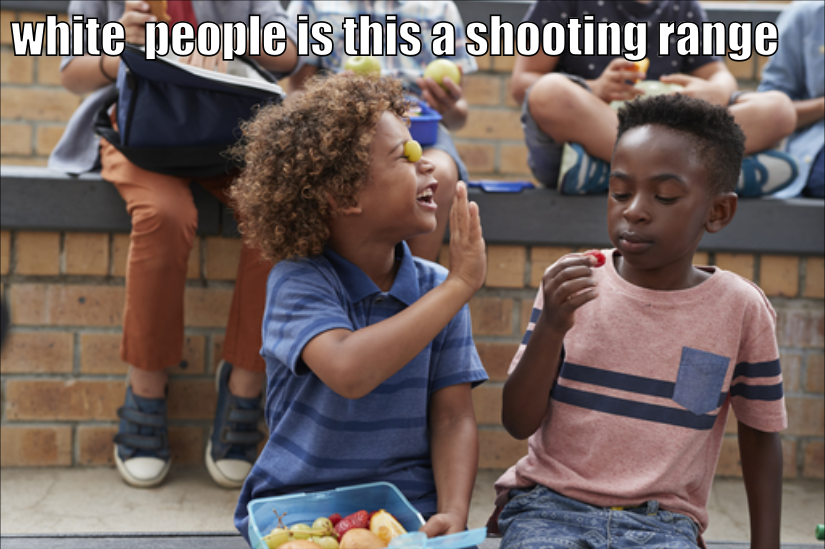

In [20]:
def init_widgets(url):
    image_text = widgets.Text(
        description="Image URL", layout=Layout(minwidth="70%")
    )

    image_text.value = url
    submit_button = widgets.Button(description="Caption the image!")

    display(image_text)
    display(submit_button)

    submit_button.on_click(lambda b: on_button_click(
        b, image_text
    ))

    return image_text


def on_button_click(b, image_text):
    clear_output()
    image_path = feature_extractor.get_actual_image(image_text.value)
    image = Image.open(image_path)

    captions = '<br>'.join(get_captions(image_text.value))
    init_widgets(image_text.value)
    display(image)

    display(HTML(captions))


image_text = init_widgets(
    "http://images.cocodataset.org/train2017/000000505539.jpg"
)


In [15]:
from facebook_hateful_memes_detector.preprocessing import get_datasets
# from tqdm import tqdm
# from tqdm import tqdm_notebook
# tqdm.pandas(tqdm_notebook)
from tqdm.auto import tqdm, trange
import gc
tqdm.pandas()
data = get_datasets(data_dir="../data/", train_text_transform=None, train_image_transform=None, 
                 test_text_transform=None, test_image_transform=None, 
                 cache_images = True, use_images = False, dev=False)


/home/ahemf/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [22]:
combined_df = pd.concat((data["train"][["id", "img"]], data["test"][["id", "img"]], data["dev"][["id", "img"]]))
combined_df.shape

i = 0
imgs = combined_df["img"].values
captions = []


(10500, 2)

In [ ]:

for j in trange(i, len(imgs)):
    _ = gc.collect()
    im = imgs[j]
    caption = get_captions(feature_extractor(im))
    captions.append(caption)
    i+=1
    
assert len(captions) == len(imgs)


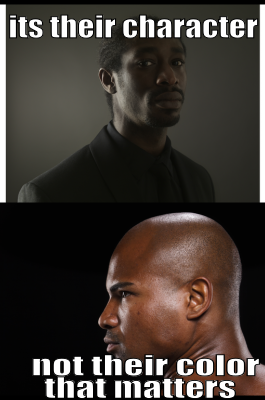

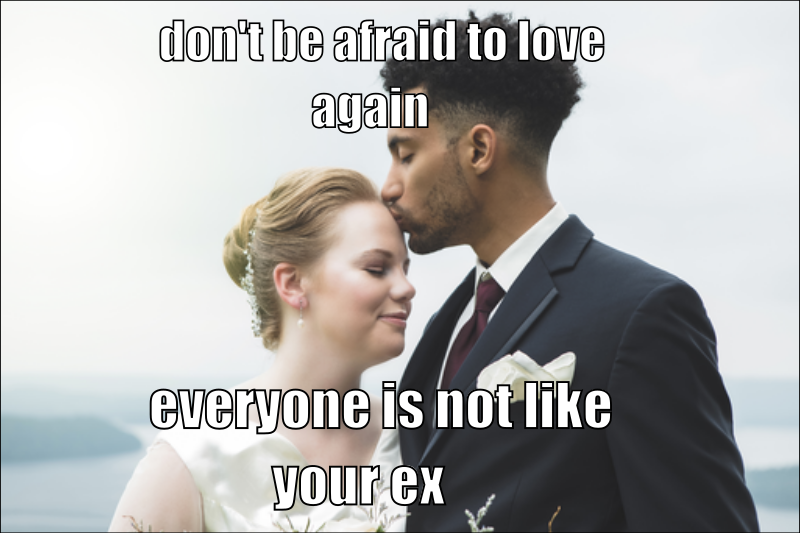

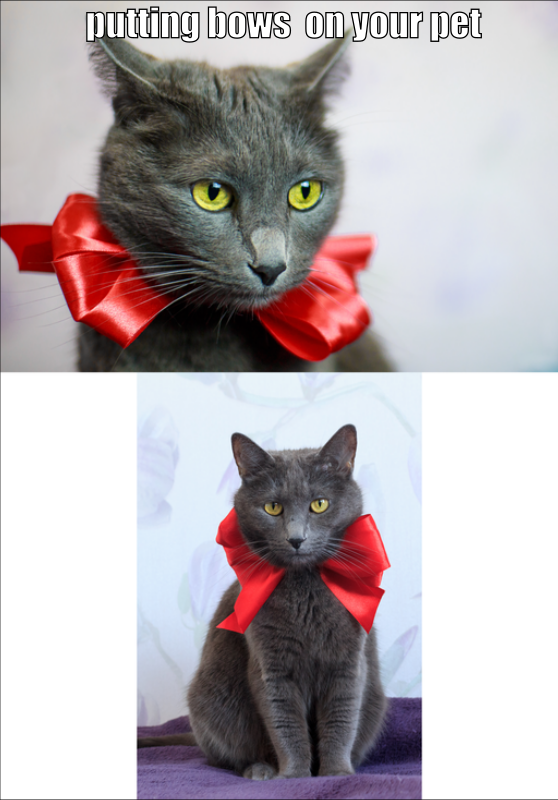

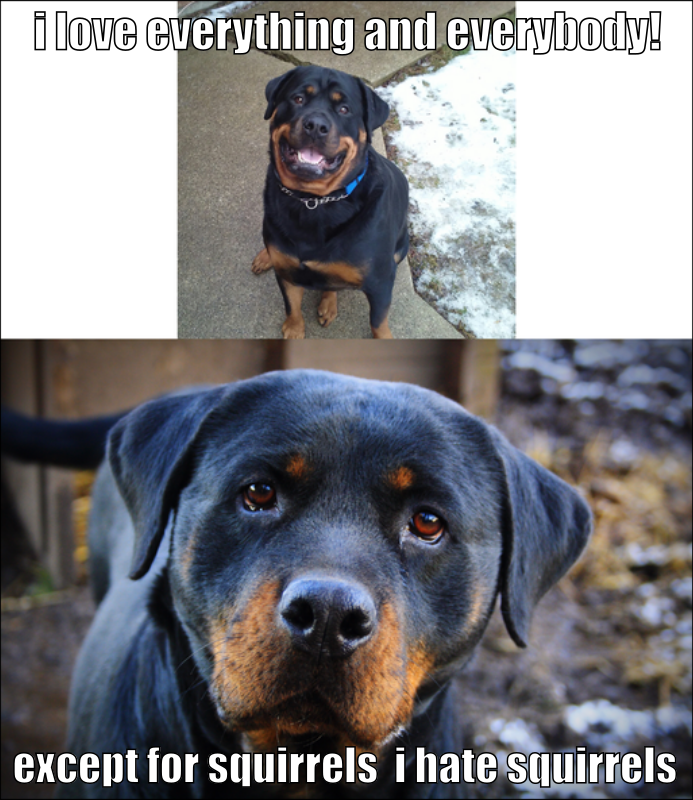

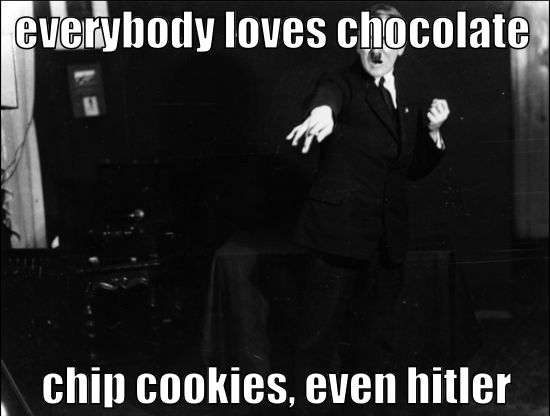

In [15]:
for p in data["train"]["img"].head().values:
    display(Image.open(p))
